# What does the finance minister tweet about?

We crawled the web for tweets posted by the Zimbabwean finance minister, Prof. Ncube, and conducted sentiment analysis.

The data set was retrieved on Thursday, 3 October 2019.

In [1]:
# Header
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

In [16]:
# Handle warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# The usual suspects ...
import os
import glob
import string
import re
import pyLDAvis.gensim
import pandas_profiling
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sentiment.analyse import *

In [17]:
# Settings
sns.set_style('white')

## Preprocessing

In [4]:
# Format the data
df = format_data('finance-minister-tweets.csv')

In [18]:
# Removing @user mentions and links
for i in range(len(df)):
    df.loc[i, 'text'] = strip_all_entities(strip_links(df.loc[i, 'text']))

df['text'].head(10)

0             That was some speech from the technocrat
1    If you knew you would give a brief but then th...
2    Indeed Prof But hiring of more bureaucrats for...
3    MthuliNcube is in his world of his own Imagine...
4           Biti benefited from Chinamasa’s foundation
5    Useless directive when the commodity is unavai...
6    Thank you Sen Corker Sen Coons That law will n...
7    RBZ and can take a cue from this twitter com C...
8    Domestic borrowing now at 9 5bn external debt ...
9    Mushavi indeed it is locals need to be protect...
Name: text, dtype: object

In [19]:
# Formatting
document = create_document_corpus(df, 'text')
text_corpus = remove_common_words_and_tokenize(document)
refined_text_corpus = remove_words_appearing_only_once(text_corpus)
no_emojis_refined_text_corpus = remove_emojis(refined_text_corpus)
no_empty_tokens_refined_text_corpus = remove_empty_corpus_tokens(no_emojis_refined_text_corpus)

# Printing the top 10
#pprint(no_empty_tokens_refined_text_corpus[:5])

In [20]:
# Create dictionary of document
bag = corpora.Dictionary(no_empty_tokens_refined_text_corpus)
bag.save('models/mthulincube.dict')

# Converting document to a vector (bag-of-words)
corpus = [bag.doc2bow(text) for text in no_empty_tokens_refined_text_corpus]
corpora.MmCorpus.serialize('models/mthulincube.mm', corpus)

In [21]:
# Initializing tf-idf
tfidf, corpus_tfidf = create_tfidf_model(corpus)

In [22]:
# Initializing an LSI transformation
lsi, corpus_lsi = create_lsi_model(corpus_tfidf, model_name='mthulincube', id2word=bag, num_topics=10)
lsi.print_topics()

TypeError: __init__() got multiple values for argument 'num_topics'

In [36]:
query_similarity(doc='God')

Tweet Rank #1:	Weight: 0.9991528391838074
Raw text: Expect no response from this useless idiot He will just post and varnish Once Zim recovers such people must be put down or hold accountable kwete zve bygones

Tweet Rank #2:	Weight: 0.9987138509750366
Raw text: 1 Who is behind the current brutal evictions of villagers from resettlement areas around Arda Balu Estate koMadiliza People who have resettled for yrs are told to go back abavela khona within 7 days

Tweet Rank #3:	Weight: 0.9978160858154297
Raw text: But said they can get forex from banks freely

Tweet Rank #4:	Weight: 0.9976624250411987
Raw text: That is alsi planned Hapana nhubu iri kuzoyenda kutirongo Its all nonsense The whole ZanuPf has to go to jail from ED all the way down before anything make sense

Tweet Rank #5:	Weight: 0.9976297616958618
Raw text: Yes the only information about Zim exchange is what we have from Zim authorities which the World have no idea how it is generated Remember an exchange rate is determined t

In [38]:
lda, corpus_lda = create_lda_model(corpus_tfidf)

In [39]:
lda.print_topics()

[(0,
  '0.003*"anything" + 0.002*"forex" + 0.002*"democracy" + 0.002*"1" + 0.002*"yu" + 0.002*"us" + 0.002*"people" + 0.002*"guys" + 0.002*"one" + 0.002*"zimbabwe"'),
 (1,
  '0.002*"know" + 0.002*"true" + 0.002*"us" + 0.002*"people" + 0.002*"zimbabwe" + 0.002*"away" + 0.002*"com" + 0.002*"twitter" + 0.002*"00" + 0.002*"unemployed"'),
 (2,
  '0.005*"money" + 0.004*"us" + 0.004*"tax" + 0.003*"2" + 0.003*"people" + 0.003*"zimbabwe" + 0.003*"get" + 0.003*"usd" + 0.003*"minister" + 0.003*"1"'),
 (3,
  '0.004*"response" + 0.003*"twitter" + 0.003*"com" + 0.003*"seeing" + 0.003*"mistake" + 0.003*"ediot" + 0.003*"pic" + 0.003*"get" + 0.002*"brought" + 0.002*"good"'),
 (4,
  '0.003*"technocrat" + 0.003*"bomboclat" + 0.002*"currency" + 0.002*"herald" + 0.002*"us" + 0.002*"usd" + 0.002*"bond" + 0.002*"quoting" + 0.002*"0" + 0.002*"com"')]

In [42]:
df_topic_sent_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=no_empty_tokens_refined_text_corpus)

In [44]:
# Formatting
df_dominant_topic = df_topic_sent_keywords.reset_index()
df_dominant_topic.columns = ['document_number', 'dominant_topic', 'topic_percentage_contribution', 'keywords', 'text']
df_dominant_topic.head(10)

,document_number,dominant_topic,topic_percentage_contribution,keywords,text
0,0,4.0,0.7306,"technocrat, bomboclat, currency, herald, us, u...","[speech, technocrat]"
1,1,3.0,0.4589,"response, twitter, com, seeing, mistake, ediot...","[knew, would, give, brief, response, except, c..."
2,2,2.0,0.6172,"money, us, tax, 2, people, zimbabwe, get, usd,...","[indeed, prof, hiring, bureaucrats, purposes, ..."
3,3,0.0,0.5286,"anything, forex, democracy, 1, yu, us, people,...","[mthulincube, world, imagine, someone, doesnt,..."
4,4,3.0,0.7932,"response, twitter, com, seeing, mistake, ediot...","[biti, benefited, foundation]"
5,5,1.0,0.5430,"know, true, us, people, zimbabwe, away, com, t...","[useless, directive, commodity, unavailable, c..."
6,6,3.0,0.4600,"response, twitter, com, seeing, mistake, ediot...","[thank, sen, sen, law, doubt, help, africa, be..."
7,7,3.0,0.8839,"response, twitter, com, seeing, mistake, ediot...","[rbz, take, cue, twitter, com, status]"
8,8,1.0,0.5389,"know, true, us, people, zimbabwe, away, com, t...","[domestic, borrowing, 9, 5bn, external, debt, ..."
9,9,2.0,0.9191,"money, us, tax, 2, people, zimbabwe, get, usd,...","[indeed, locals, need, protected, unfair, comp..."


In [45]:
# Formatting
sent_topic_sorted_df_mallet = pd.DataFrame()
sent_topic_out_df_grouped = df_topic_sent_keywords.groupby('dominant_topic')

for item, group in sent_topic_out_df_grouped:
    sent_topic_sorted_df_mallet = pd.concat([sent_topic_sorted_df_mallet,
                                             group.sort_values(['percentage_distribution'],
                                                               ascending=False).head(1)],
                                            axis=0)
    
# Reset index
sent_topic_sorted_df_mallet.reset_index(drop=True, inplace=True)

# Formatting
sent_topic_sorted_df_mallet.columns = ['topic_number', 'topic_percentage_contribution', 'keywords', 'representative_text']

# Display
sent_topic_sorted_df_mallet.head(10)

,topic_number,topic_percentage_contribution,keywords,representative_text
0,0.0,0.9687,"anything, forex, democracy, 1, yu, us, people,...","[cant, continue, enough, enough, must, resign,..."
1,1.0,0.9709,"know, true, us, people, zimbabwe, away, com, t...","[let, tell, one, thing, noticed, zimbabwe, lik..."
2,2.0,0.9759,"money, us, tax, 2, people, zimbabwe, get, usd,...","[problem, professor, weeks, ago, said, governm..."
3,3.0,0.9646,"response, twitter, com, seeing, mistake, ediot...","[lot, cross, puts, across, unite, us, seem, en..."
4,4.0,0.9696,"technocrat, bomboclat, currency, herald, us, u...","[finance, minister, says, mthu, high, court, t..."


Text(0.5, 1.0, 'Distribution of Document Word Counts')

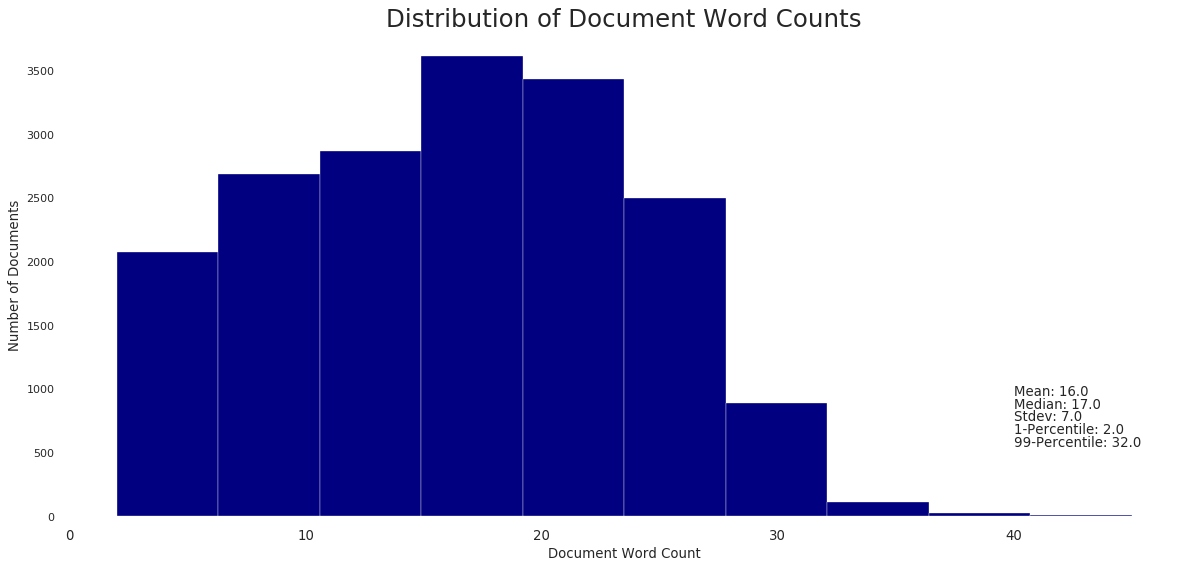

In [50]:
# Document length
doc_length = [len(d) for d in df_dominant_topic['text']]

# Plotting
plt.figure(figsize=(18, 8), dpi=80)
plt.hist(doc_length, bins=10, color='navy')
plt.text(40, 950, 'Mean: ' + str(round(np.mean(doc_length))), fontsize=12)
plt.text(40, 850, 'Median: ' + str(round(np.median(doc_length))), fontsize=12)
plt.text(40, 750, 'Stdev: ' + str(round(np.std(doc_length))), fontsize=12)
plt.text(40, 650, '1-Percentile: ' + str(round(np.quantile(doc_length, q=0.01))), fontsize=12)
plt.text(40, 550, '99-Percentile: ' + str(round(np.quantile(doc_length, q=0.99))), fontsize=12)
plt.xticks(size=12)
plt.ylabel('Number of Documents', fontsize=12)
plt.xlabel('Document Word Count', fontsize=12)
plt.title('Distribution of Document Word Counts', fontsize=22)

In [51]:
# Formatting
data = word_counts_of_topic_keywords(lda, no_empty_tokens_refined_text_corpus)

Text(0.5, 1.05, 'Word Count and Importance of Topic Keywords')

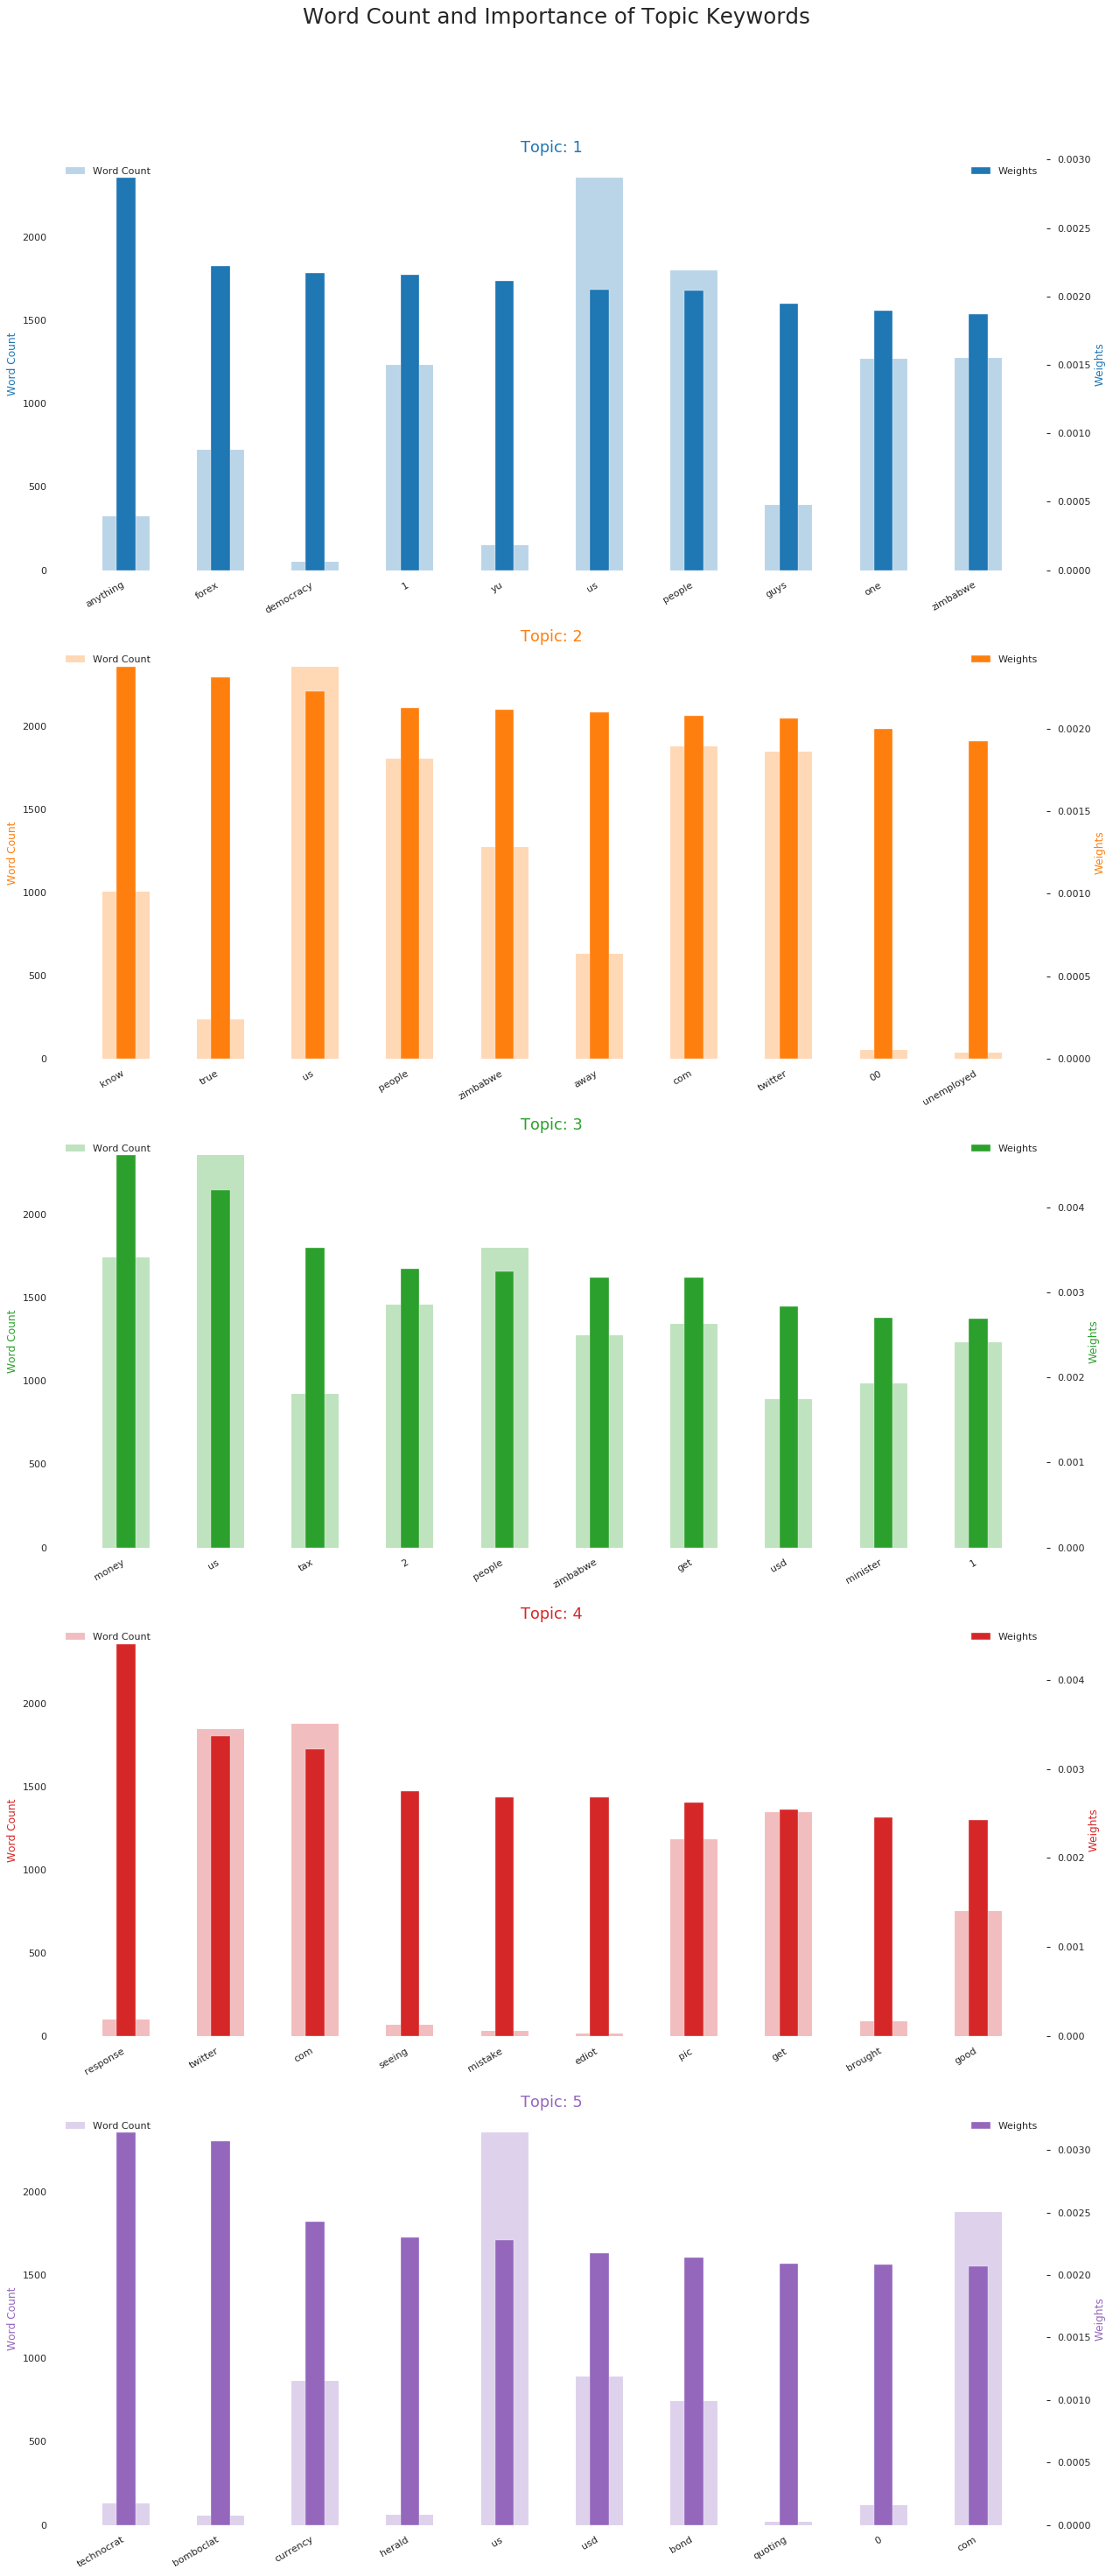

In [52]:
# Plotting
fig, axes = plt.subplots(5, 1, figsize=(16, 35), sharey=True, dpi=80)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height='word_count', data=data.loc[data.topic_id == i, :], color=cols[i], width=.5, alpha=.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height='importance', data=data.loc[data.topic_id == i, :], color=cols[i], width=.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylabel('Weights', color=cols[i])
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(data.loc[data.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
    ax.legend(loc='upper left')
    ax_twin.legend(loc='upper right')
fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)

In [53]:
# Sentence Coloring of N Sentences
dominant_topics, topic_percentages = topics_per_document(model=lda, corpus=corpus, end=-1)

In [54]:
# Distribution of dominant topics in each document
df_2 = pd.DataFrame(dominant_topics, columns=['document_id', 'dominant_topic'])
dominant_topic_in_each_document = df_2.groupby('dominant_topic').size()
df_dominant_topic_in_each_document = dominant_topic_in_each_document.to_frame(name='count').reset_index()

In [55]:
# Total topic distribution by actual weight
topic_weightage_by_document = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_document.sum().to_frame(name='count').reset_index()

In [56]:
# Top 3 keywords for each topic
topic_top_3_words =  [(i, topic) for i, topics in lda.show_topics(formatted=False) for j, (topic, wt) in enumerate(topics) if j < 3]
df_top_3_words_stacked = pd.DataFrame(topic_top_3_words, columns=['topic_id', 'words'])
df_top_3_words = df_top_3_words_stacked.groupby('topic_id').agg(', \n'.join)
df_top_3_words.reset_index(level=0, inplace=True)

Text(0.5, 1.0, 'Number of Documents by Topic Weightage')

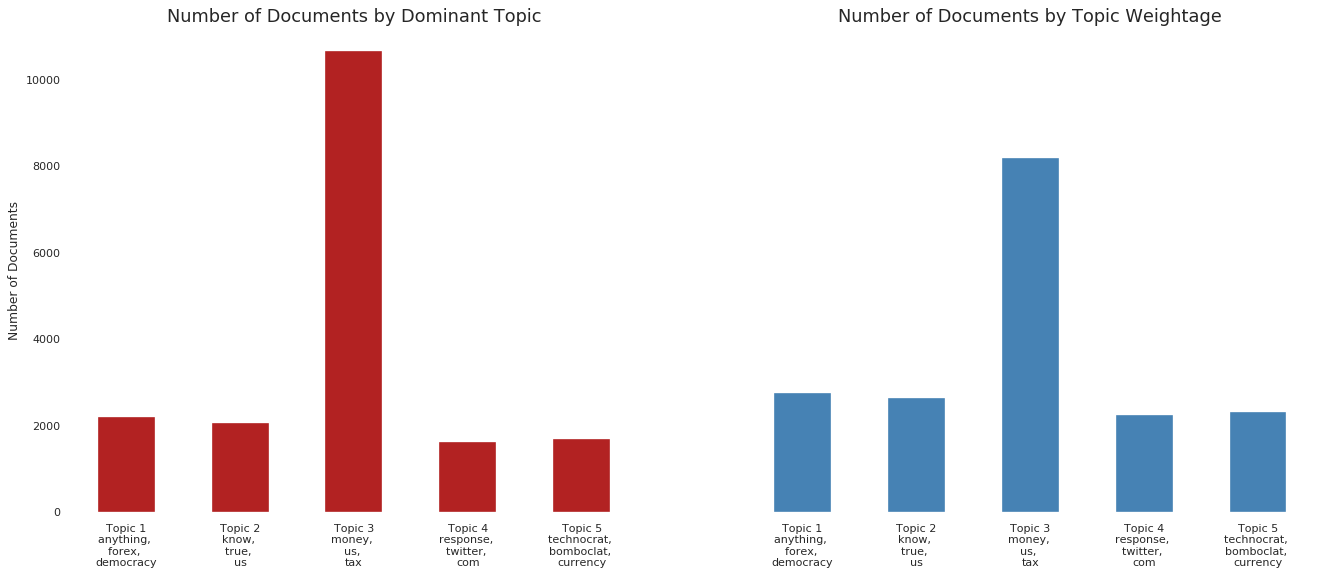

In [57]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=80, sharey=True)

# Topic distribution by dominant topics
ax1.bar(x='dominant_topic', height='count', data=df_dominant_topic_in_each_document, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_document.dominant_topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x+1) + '\n' + df_top_3_words.loc[df_top_3_words.topic_id == x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=16))
ax1.set_ylabel('Number of Documents')

# Topic distribution by topic weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=16))

In [58]:
append_cleaned_text(no_emojis_refined_text_corpus, df, 'cleaned_text')

In [59]:
# Create polarity and subjectivity columns
polarity_and_subjectivity(df=df, column='cleaned_text')

(None, None)

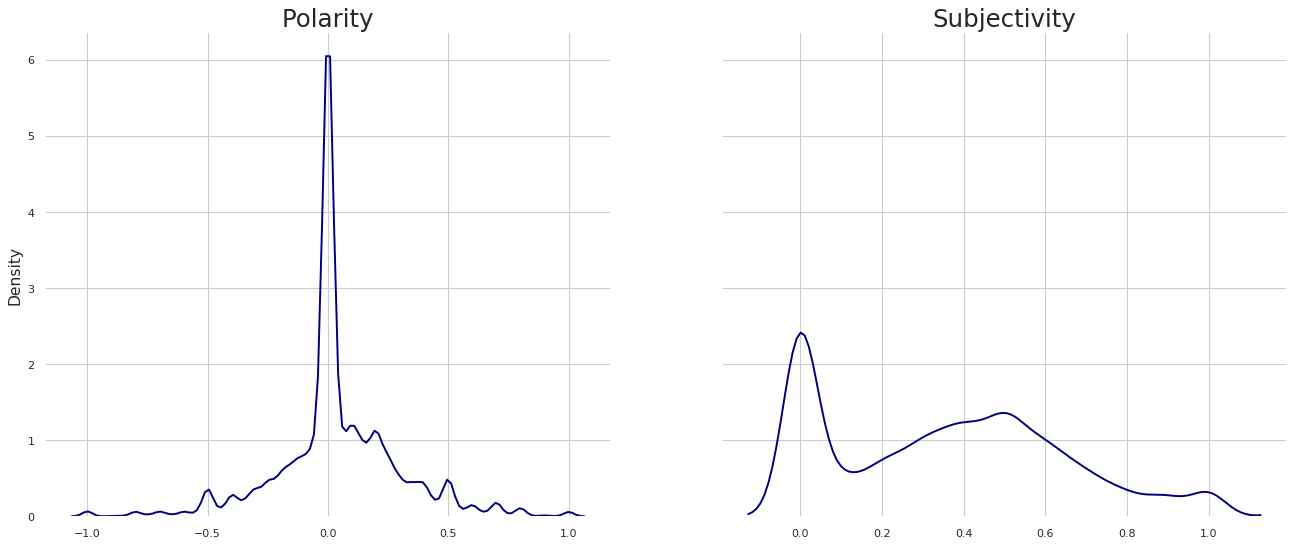

In [63]:
# Plotting
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=80, sharey=True)
sns.distplot(df['polarity'], ax=ax1, color='navy', hist=False)
sns.distplot(df['subjectivity'], ax=ax2, color='navy', hist=False)
ax1.set_title('Polarity', fontsize=22), ax2.set_title('Subjectivity', fontsize=22)
ax1.set_ylabel('Density', fontsize=14)
ax1.set_xlabel(''), ax2.set_xlabel('')
ax1.grid(), ax2.grid()